1. Problema: 
    - Encontrar os melhores clientes

3. *Descrição das Colunas do Dataset*

| Coluna       | Descrição |
|-------------|-----------|
| `invoiceno`  | Número da fatura. Um identificador único para cada transação realizada. |
| `stockcode`  | Código do produto. Um identificador único para cada item vendido. |
| `description` | Descrição do produto. O nome ou detalhes do item comprado. |
| `quantity`   | Quantidade de itens comprados em uma única transação. |
| `invoicedate` | Data e hora da compra, indicando quando a transação ocorreu. |
| `unitprice`  | Preço unitário do produto, ou seja, o valor de um único item. |
| `customerid` | Identificação do cliente. Um número único que representa cada comprador. |
| `country`    | País de origem do cliente que realizou a compra. |


1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento:
      - Alto Ticket Médio.*
      - Alto LTV.*
      - Baixa Recência.*
      - Alto basket size.*
      - Baixa Probabilidade de Churn.*
      - Alta Previsão LTV.*
      - Alta Propensão de Compra.*
    
    - Custo:
      - Baixa taxa de devolução.
     
     - Experiência de Compra:
       - Média Alta das Avaliação

2. Quantos clientes farão parte do grupo?
   - Número Total de Clientes
   - % do grupo Insiders
  
3. Quais as principais caracteristicas desses clientes?
    - Escrever Características do Cliente:
      - Idade
      - Localização
    - Escrever Características do Consumo.
      - Atributos da Clusterização.
  
4. Qual a porcentagem de contribuição do faturameto vinda do Insiders?
   - Faturamento total do ano
   - Faturamento do grupo Insiders
  
5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - LTV do grupo Insiders
    - Análise de Cohort*
  
6. Quais as condições para uma pessoa ser elegível ao Insiders?
   - Definir a periodicidade ( 1 mes, 3 meses )
   - A pessoa precisa ser similar com uma pessoa do grupo.
  
7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a periodicidade ( 1 mes, 3 meses )
   - A pessoa precisa ser não similar com uma pessoa do grupo.
8. Qual a garantia que o programa Insiders é melhor que o restante da base?
   - Teste A/B
   - Teste A/B Bayesiano
   - Teste de Hipoteses
9.  Quais ações o time de marketing pode realizar para aumentar o faturamento?  
    - Desconto
    - Preferencia de Compra

# 1.0 IMPORTS

In [74]:
import pandas   as pd
import numpy    as np

import matplotlib.pyplot    as plt
import seaborn              as sns
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.model_selection import train_test_split
from sklearn import cluster as c
from sklearn import metrics as m

import umap.umap_ as umap

import re

import warnings
warnings.filterwarnings('ignore')

## 1.1 Loading Data

In [75]:
df = pd.read_csv('./data/ecommerce.csv', encoding="ISO-8859-1")
df = df.drop('Unnamed: 8', axis=1)

## 1.2 Helper Functions

In [76]:
def descriptive_analysis(num_attrs):

    # central tendency - mean, media
    ct1 = pd.DataFrame(num_attrs.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attrs.apply(np.median)).T

    # disperation - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attrs.apply(np.std)).T
    d2 = pd.DataFrame(num_attrs.apply(min)).T
    d3 = pd.DataFrame(num_attrs.apply(max)).T
    d4 = pd.DataFrame(num_attrs.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attrs.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attrs.apply(lambda x: x.kurtosis())).T

    # concatenate
    m = pd.concat([d2,d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
    m.columns = ['attrs', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    return m

# 2.0 DATA DESCRIPTION

In [77]:
df2 = df.copy()

## 2.1 Rename columns

In [78]:
df2.columns = [x.lower() for x in df2.columns]
columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df2.columns = columns
df2.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
332170,566060,23086,ZINC STAR T-LIGHT HOLDER,6,6-Sep-17,2.46,NaN,United Kingdom


## 2.2 Data Dimension

In [79]:
print('Columns:', df2.shape[1])
print('Rows:', df2.shape[0])

Columns: 8
Rows: 541909


## 2.3 Data Types

In [80]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 2.4 Check NA

In [81]:
df2.isnull().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [82]:
df2[df2['customer_id'].isna()]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
622,536414,22139,NaN,56,29-Nov-16,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,29-Nov-16,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,29-Nov-16,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,29-Nov-16,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,29-Nov-16,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,7-Dec-17,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,7-Dec-17,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,7-Dec-17,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,7-Dec-17,10.79,NaN,United Kingdom


Unfortunately, for this problem, customerid is very important. And since it is not possible to identify these columns, I will remove them. Next cycle I will tratment this problem.

## 2.5 Replace NA

In [83]:
# remove na
df2 = df2.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.0f}%'.format( ( (1-(df2.shape[0] / df.shape[0])) * 100 ))) # ( 1 - (new shape / oldest shape) ) * 100

Removed data: 25%


## 2.6 Change dtypes

In [84]:
df2.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [85]:
# invoice data
df2['invoice_date'] = pd.to_datetime(df2['invoice_date'], format='%d-%b-%y')

# customer id
df2['customer_id'] = df2['customer_id'].astype(int)

## 2.7 Descriptive Statistical

In [86]:
num_attributes = df2.select_dtypes(include=['int64', 'float64', 'int32', 'float32'])
categorical_attributes = df2.select_dtypes(exclude=['int64', 'float64', 'int32', 'float32', 'datetime64[ns]'])


### 2.7.1 Numerical Attributs

In [87]:
descriptive_analysis(num_attributes)

,attrs,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


#### <font color='red'> 2.7.1.1 Numerical Attributs - Investigating </font>

1. Quantity negativa ( pode ser devolução )
2. Preço Unitário igual a zero ( pode ser promoção ? )

### 2.7.2 Categorical Attributs

**Invoice No**

In [88]:
# problema: temos invoice com letras e numeros
# df2['invoice_no'].astype(int)

# identificacao
df_letter_invoices = df2.loc[df2['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), : ]

print(f'Total number of invoice: {len(df_letter_invoices)}')
print('Total number of negative quantify: {}'.format(len(df_letter_invoices[df_letter_invoices['quantity'] < 0])))


Total number of invoice: 8905
Total number of negative quantify: 8905


**Stock Code**

In [89]:
# check stock code only characters
df2.loc[df2.stock_code.apply(lambda x: bool( re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

#acao:
## 1. remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

**Description**

In [90]:
df2.head()

#acao: dele description

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


**Country**

In [91]:
df2.country.unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       'Unspecified', 'Brazil', 'USA', 'European Community', 'Bahrain',
       'Malta', 'RSA'], dtype=object)

In [92]:
df2['country'].value_counts(normalize=True)

country
United Kingdom          0.889509
Germany                 0.023339
France                  0.020871
EIRE                    0.018398
Spain                   0.006226
Netherlands             0.005828
Belgium                 0.005086
Switzerland             0.004614
Portugal                0.003638
Australia               0.003095
Norway                  0.002669
Italy                   0.001974
Channel Islands         0.001863
Finland                 0.001708
Cyprus                  0.001529
Sweden                  0.001136
Austria                 0.000986
Denmark                 0.000956
Japan                   0.000880
Poland                  0.000838
USA                     0.000715
Israel                  0.000615
Unspecified             0.000600
Singapore               0.000563
Iceland                 0.000447
Canada                  0.000371
Greece                  0.000359
Malta                   0.000312
United Arab Emirates    0.000167
European Community      0.000150
RS

In [93]:
df2[['customer_id', 'country']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False)

,country,customer_id
35,United Kingdom,3950
14,Germany,95
13,France,87
30,Spain,31
3,Belgium,25
32,Switzerland,21
26,Portugal,19
18,Italy,15
12,Finland,12
1,Austria,11


In [94]:
categorical_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [95]:
# invoice number

#categorical_attributes.invoice_no.astype(int)
len( categorical_attributes.loc[categorical_attributes.invoice_no.apply(lambda x: bool(re.search('[^0-9]+', x ))), 'invoice_no'].drop_duplicates() )

3654

In [96]:
# # stock code
# at_least_one_string = len(categorical_attributes.loc[categorical_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'])
# print(at_least_one_string)

#
categorical_attributes.loc[categorical_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

#df2.loc[categorical_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]$', x))), :].head(30)

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

In [97]:
categorical_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


# 3.0 FEATURE FILTERING

In [98]:
df3 = df2.copy()

In [99]:
# unit price > 0.0
df3 = df3.loc[df3['unit_price'] > 0.04, :]

df3 = df3[~df3['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'C2'])]

# description
df3 = df3.drop(columns='description', axis=1)

# map
df3 = df3[~df3['country'].isin(['European Community', 'Unspecified'])]

df3_returns = df3.loc[df3['quantity'] < 0, :]
df3_purchase = df3.loc[df3['quantity'] > 0, :]

# 4.0 FEATURE ENGINEERING

In [100]:
df4 = df3.copy()

## 4.1 Feature Creation

In [101]:
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

In [102]:
# faturamento: quantity * price
df3_purchase['gross_revenue'] = df3_purchase['quantity'] * df3_purchase['unit_price']

# monetary
df_monetary = df3_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

In [103]:
# recenct 
df_recency = df3_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3_purchase['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

In [104]:
# frequency
df_frequency = df3_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_frequency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
dtype: int64

In [105]:
# avg ticket
df_avg_ticket = df3_purchase.loc[df3['quantity'] > 0, ['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_avg_ticket['avg_ticket'] = np.around(df_avg_ticket['avg_ticket'], 2)
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
dtype: int64

In [106]:
# returns
df_returns = df3_purchase[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'returns'})
df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
invoice_no       27
avg_ticket       27
returns           0
dtype: int64

# 5.0 EDA ( Exploratory Data Analysis )

In [107]:
df4 = df_ref.dropna().copy()
df4.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
returns          0
dtype: int64

# 6.0 Data Preparation

In [136]:
from sklearn import preprocessing as pp

In [137]:
df5 = df4.copy()

In [138]:
#ss = pp.StandardScaler()
ss = pp.MinMaxScaler()


df5['gross_revenue'] = ss.fit_transform( df5[['gross_revenue']] )
df5['recency_days'] = ss.fit_transform( df5[['recency_days']] )
df5['invoice_no'] = ss.fit_transform( df5[['invoice_no']] )
df5['avg_ticket'] = ss.fit_transform( df5[['avg_ticket']] )
df5['returns'] = ss.fit_transform( df5[['returns']] )


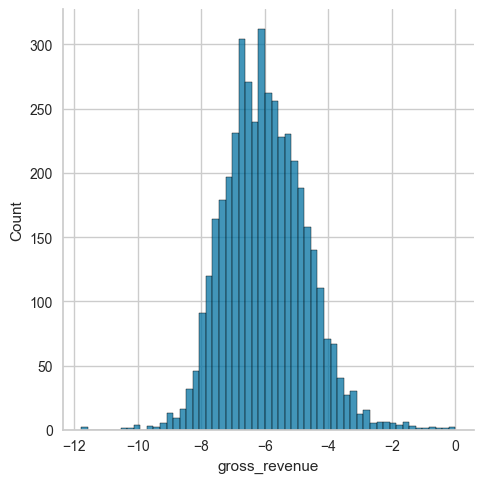

In [140]:
sns.displot(np.log ( df5['gross_revenue']))

# 7.0 Feature Selection

In [141]:
df6 = df5.copy()

# 8.0 Hyperparameter Fine-Tunning

In [142]:
df7 = df6.drop(columns=['customer_id'])
X = df7.copy()

In [143]:
clusters = [2,3,4,5,6,7]

## 7.1 Within-Cluster Sum of Square ( WSS )

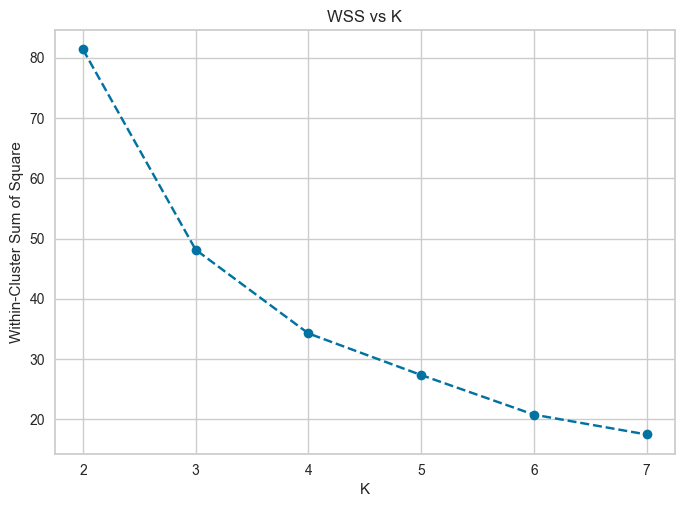

In [144]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    # model training
    kmeans.fit(X)
    # validation
    wss.append(kmeans.inertia_)
# plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square');
plt.title('WSS vs K');

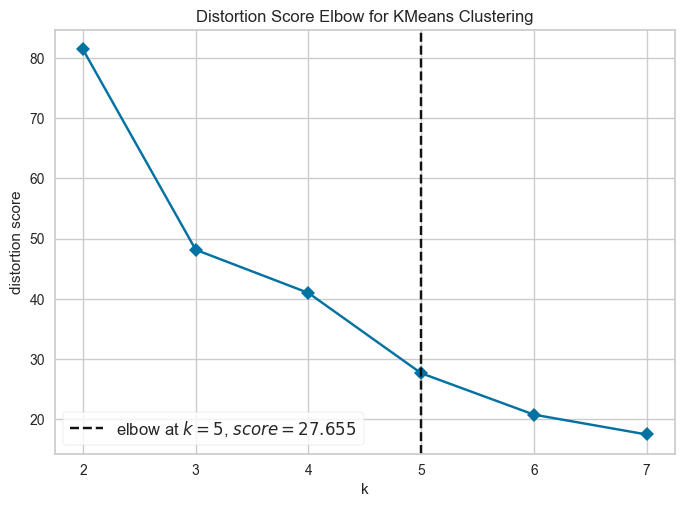

In [145]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

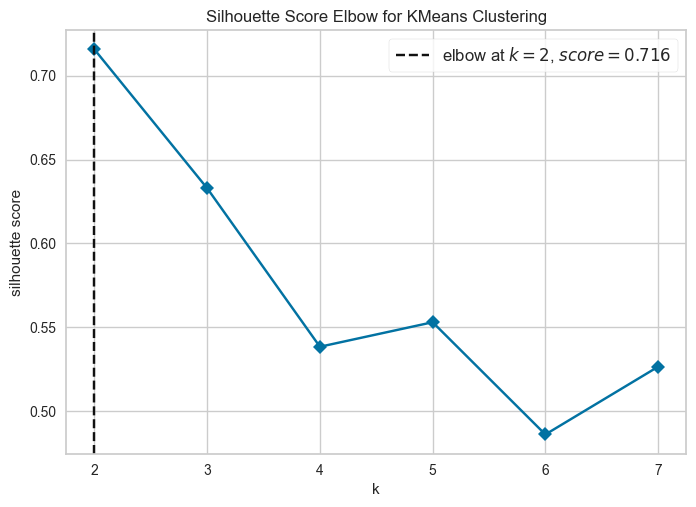

In [146]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Analysis

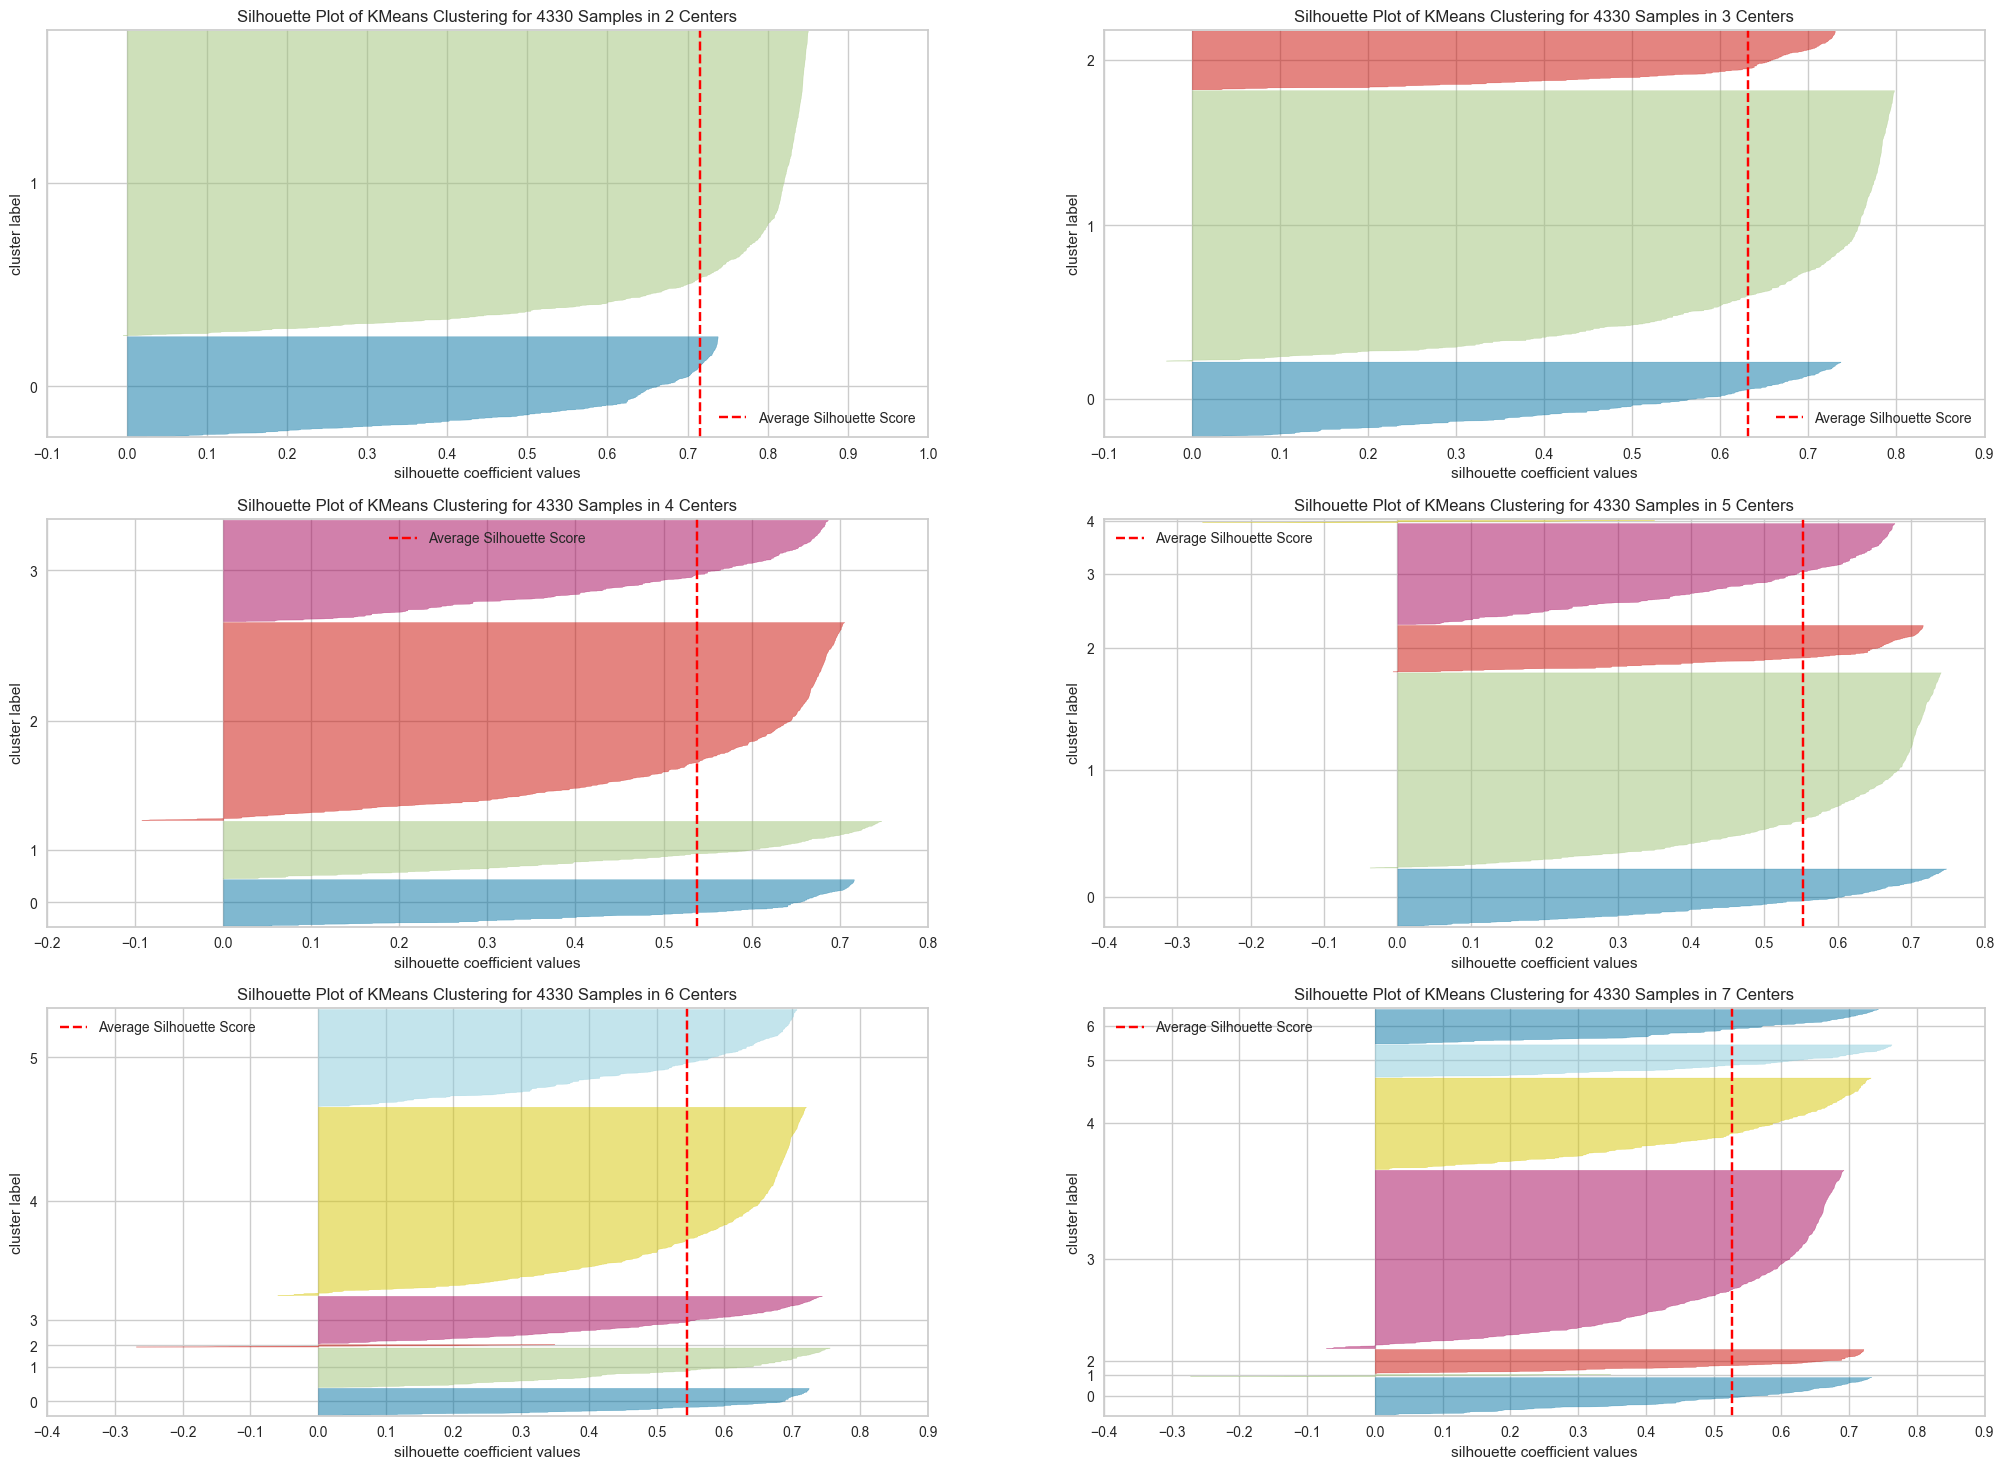

In [147]:
fig, ax = plt.subplots(3, 2, figsize=(25,18))
for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100,  random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

# 9.0 Model Training

In [125]:
df8 = df7.copy()

## 8.1 K-Means

In [148]:
# model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training 
kmeans.fit(X)

# clustering
labels = kmeans.labels_

## 8.2 Cluster Validation

In [149]:
print('WSS Value: {}'.format(kmeans.inertia_))
print('SS Value: {:.2f}'.format(m.silhouette_score(X, labels, metric='euclidean')))


WSS Value: 48.1474425994101
SS Value: 0.63


# 10.0 Cluster Analysis

In [150]:
df6['cluster'] = labels
df9 = df6.copy()
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,0.160976,2
1,13047,0.011567,0.150134,0.039024,0.000218,0.039024,1
2,12583,0.024009,0.005362,0.068293,0.000347,0.068293,1
3,13748,0.003384,0.254692,0.019512,0.000412,0.019512,0
4,15100,0.003125,0.892761,0.009756,0.003756,0.009756,2


## 9.1 Visualization Inspection

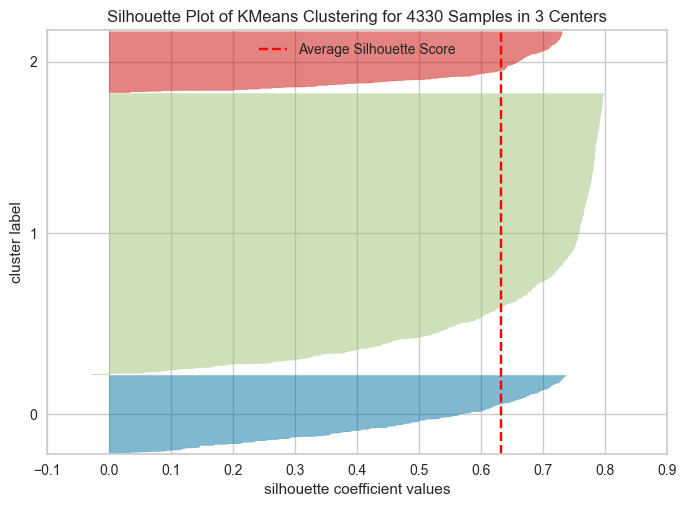

In [151]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 2dplot

In [152]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,returns,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,0.160976,2
1,13047,0.011567,0.150134,0.039024,0.000218,0.039024,1
2,12583,0.024009,0.005362,0.068293,0.000347,0.068293,1
3,13748,0.003384,0.254692,0.019512,0.000412,0.019512,0
4,15100,0.003125,0.892761,0.009756,0.003756,0.009756,2


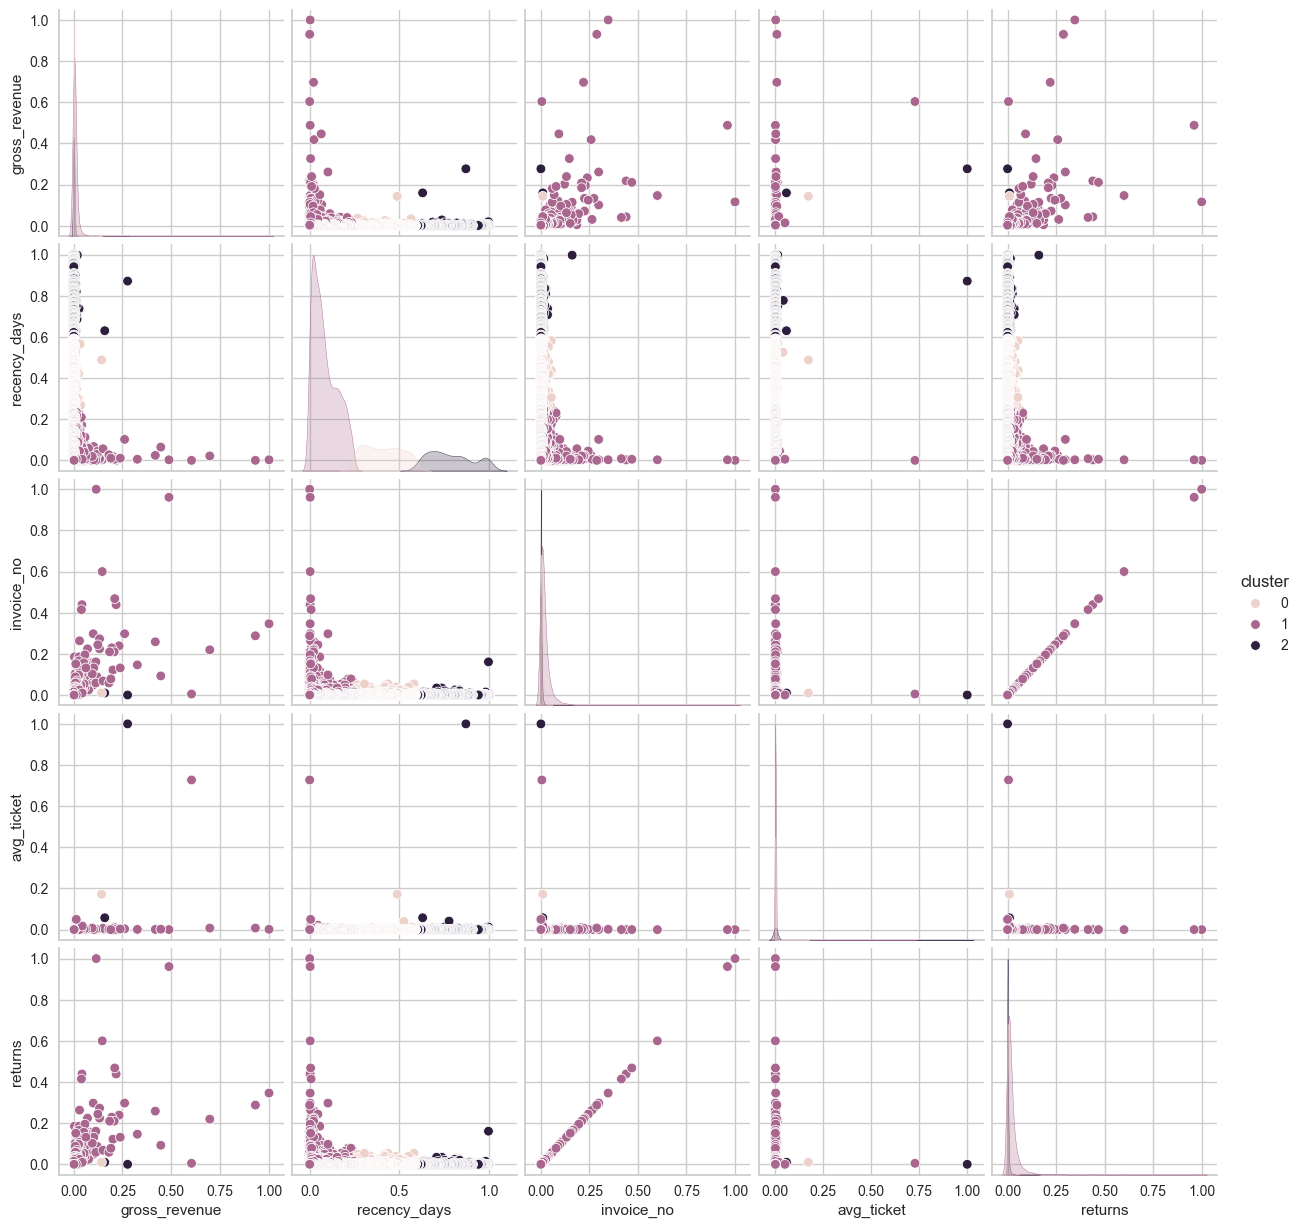

In [153]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP - t-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

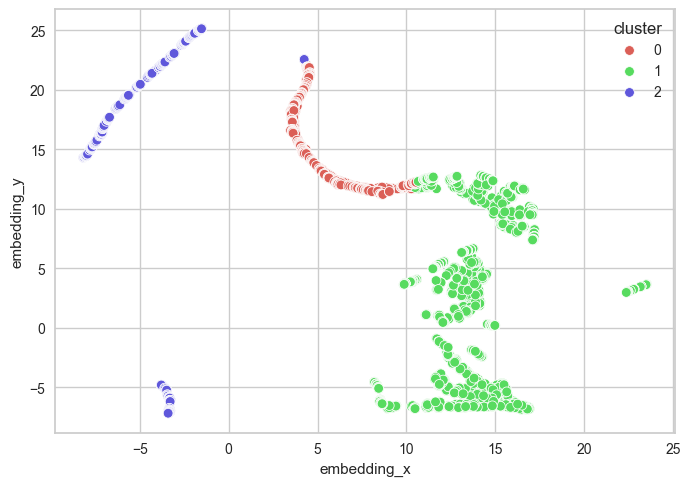

In [158]:
reducer = umap.UMAP(n_neighbors=90, random_state=42)
embedding = reducer.fit_transform(X)

df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len( df_viz['cluster'].unique())), data=df_viz)

## Plot 3D

In [155]:
df9 = df9.rename(columns={'invoice_no':'frequency'})

fig = px.scatter_3d(df9, x='recency_days', y='frequency', z='gross_revenue', color='cluster')
fig.show();

## 9.2 Cluster Profile

In [156]:
df9.head()

,customer_id,gross_revenue,recency_days,frequency,avg_ticket,returns,cluster
0,17850,0.019301,0.997319,0.160976,0.000208,0.160976,2
1,13047,0.011567,0.150134,0.039024,0.000218,0.039024,1
2,12583,0.024009,0.005362,0.068293,0.000347,0.068293,1
3,13748,0.003384,0.254692,0.019512,0.000412,0.019512,0
4,15100,0.003125,0.892761,0.009756,0.003756,0.009756,2


In [157]:
# number of cluster
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum())

# avg gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')

# avg recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency_days, how='inner', on='cluster')

# avg invoice_no
df_avg_invoice_no = df9[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_invoice_no, how='inner', on='cluster')

# avg ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,frequency,avg_ticket
0,0,803,18.545035,0.002772,0.409964,0.005826,0.000670
1,1,2899,66.951501,0.009567,0.084741,0.021696,0.000619
2,2,628,14.503464,0.002157,0.788669,0.001693,0.002176


# 11 Model Translation